This notebook illustrates how to apply the transformer metric to a single burst time series. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.plot import show
from scipy.special import expit, logit

from distmetrics import (
    compute_mahalonobis_dist_2d,
    compute_transformer_zscore,
    despeckle_rtc_arrs_with_tv,
    get_asf_rtc_burst_ts,
    load_transformer_model,
    read_asf_rtc_image_data,
)

from distmetrics.asf_burst_search import get_pre_post_df_rtc_df

# Parameters

In [3]:
# Papau New Guinea Landslide -  https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
BURST_ID = "T009_019294_IW2"
EVENT_TS = pd.Timestamp("2024-05-28", tz="utc")

# Los Angeles Angeles Fire - Pacific Palisades Burst
BURST_ID = 'T071-151228-IW3'
EVENT_TS = pd.Timestamp("2025-01-08", tz="utc")

DEVICE =  'cpu'

N_PRE_IMAGES = 10
APPLY_LOGIT = True

N_PRE_IMGS_PER_YEAR = 3

# Download Data

In [4]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print("# of results: ", df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  359


/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC-S1_T071-151228-IW3_20170127T135217Z_20250925T040353Z_S1A_30_v1.0 and polarization crosspol
  warn(f'No urls found for {row.opera_id} and polarization {polarization}')
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC-S1_T071-151228-IW3_20170103T135218Z_20250925T193553Z_S1A_30_v1.0 and polarization crosspol
  warn(f'No urls found for {row.opera_id} and polarization {polarization}')
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC-S1_T071-151228-IW3_20161210T135220Z_20250928T025053Z_S1A_30_v1.0 and polarization crosspol
  warn(f'No urls found for {row.opera_id} and polarization {polarization}')
/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/asf_burst_search.py:19: UserWarning: No urls found for OPERA_L2_RTC

,opera_id,acq_datetime,polarizations,track_number,geometry,url_crosspol,url_copol,dedup_id
0,OPERA_L2_RTC-S1_T071-151228-IW3_20160426T13521...,2016-04-26 13:52:13+00:00,VV+VH,71,"POLYGON ((-118.25034 34.16192, -119.1051 34.28...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160426T135213Z
1,OPERA_L2_RTC-S1_T071-151228-IW3_20160520T13521...,2016-05-20 13:52:14+00:00,VV+VH,71,"POLYGON ((-118.25055 34.16236, -119.1053 34.28...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160520T135214Z
2,OPERA_L2_RTC-S1_T071-151228-IW3_20160731T13521...,2016-07-31 13:52:18+00:00,VV+VH,71,"POLYGON ((-118.25072 34.16242, -119.10541 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160731T135218Z
3,OPERA_L2_RTC-S1_T071-151228-IW3_20160824T13521...,2016-08-24 13:52:19+00:00,VV+VH,71,"POLYGON ((-118.25008 34.16163, -119.10485 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160824T135219Z
4,OPERA_L2_RTC-S1_T071-151228-IW3_20160917T13522...,2016-09-17 13:52:20+00:00,VV+VH,71,"POLYGON ((-118.25047 34.16148, -119.10524 34.2...",https://cumulus.asf.earthdatacloud.nasa.gov/OP...,https://cumulus.asf.earthdatacloud.nasa.gov/OP...,OPERA_L2_RTC-S1_T071-151228-IW3_20160917T135220Z


In [5]:
df_prod = get_pre_post_df_rtc_df(df_rtc_ts, 
                                 EVENT_TS,
                                 n_anniversaries=3,
                                 n_pre_imgs=N_PRE_IMAGES)
df_prod.tail()

/Users/cmarshak/miniforge3/envs/distmetrics/lib/python3.13/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,opera_id,acq_datetime,polarizations,track_number,geometry,url_crosspol,url_copol,dedup_id,input_category
6,OPERA_L2_RTC-S1_T071-151228-IW3_20231128T13530...,2023-11-28 13:53:01+00:00,VV+VH,71,"POLYGON ((-118.23321 34.15926, -119.11329 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20231128T135301Z,pre
7,OPERA_L2_RTC-S1_T071-151228-IW3_20231210T13530...,2023-12-10 13:53:01+00:00,VV+VH,71,"POLYGON ((-118.23419 34.15968, -119.1143 34.28...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20231210T135301Z,pre
8,OPERA_L2_RTC-S1_T071-151228-IW3_20231222T13530...,2023-12-22 13:53:00+00:00,VV+VH,71,"POLYGON ((-118.23173 34.15971, -119.11186 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20231222T135300Z,pre
9,OPERA_L2_RTC-S1_T071-151228-IW3_20240103T13530...,2024-01-03 13:53:00+00:00,VV+VH,71,"POLYGON ((-118.23285 34.15929, -119.11293 34.2...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20240103T135300Z,pre
10,OPERA_L2_RTC-S1_T071-151228-IW3_20250109T13525...,2025-01-09 13:52:54+00:00,VV+VH,71,"POLYGON ((-118.234 34.15983, -119.11409 34.283...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T071-151228-IW3_20250109T135254Z,post


In [6]:
df_prod.acq_datetime.tolist()

[Timestamp('2021-12-14 13:52:08+0000', tz='UTC'),
 Timestamp('2021-12-20 13:52:50+0000', tz='UTC'),
 Timestamp('2022-01-01 13:52:49+0000', tz='UTC'),
 Timestamp('2022-12-15 13:52:56+0000', tz='UTC'),
 Timestamp('2022-12-27 13:52:55+0000', tz='UTC'),
 Timestamp('2023-01-08 13:52:55+0000', tz='UTC'),
 Timestamp('2023-11-28 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-10 13:53:01+0000', tz='UTC'),
 Timestamp('2023-12-22 13:53:00+0000', tz='UTC'),
 Timestamp('2024-01-03 13:53:00+0000', tz='UTC'),
 Timestamp('2025-01-09 13:52:54+0000', tz='UTC')]

**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [7]:
# Load only the filtered images (much more memory efficient!)
arrs_vv, profiles = read_asf_rtc_image_data(df_prod.url_copol)
arrs_vh, _ = read_asf_rtc_image_data(df_prod.url_crosspol)

Loading RTC data: 100%|█| 11/11 [00:11<00:00,  1.02s
Loading RTC data: 100%|█| 11/11 [00:11<00:00,  1.01s


In [8]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv, n_jobs=10, interp_method='bilinear')
arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh, n_jobs=10, interp_method='bilinear')

Despeckling: 100%|██| 11/11 [00:10<00:00,  1.05it/s]


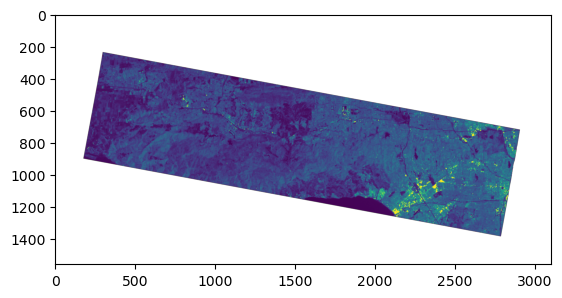

In [9]:
plt.imshow(arrs_vh_d[-1], vmin=0, vmax=.15)

In [10]:
from distmetrics.model_load import ALLOWED_MODELS
ALLOWED_MODELS

['transformer_original',
 'transformer_optimized',
 'transformer_optimized_fine',
 'transformer_anniversary_trained',
 'transformer_anniversary_trained_optimized',
 'transformer_anniversary_trained_optimized_fine',
 'transformer_v0_32',
 'transformer_v1_32']

In [11]:
transformer = load_transformer_model(lib_model_token='transformer_original', device=DEVICE)

In [12]:
def apply_logit_func(arr):
    arr_in = arr.copy()
    arr_in[np.isnan(arr_in)] = 1e-7
    return logit(arr_in)

pre_imgs_vv = arrs_vv_d[:-1]
pre_imgs_vh = arrs_vh_d[:-1]
if APPLY_LOGIT:
    pre_imgs_vv = list(map(logit, pre_imgs_vv))
    pre_imgs_vh = list(map(logit, pre_imgs_vh))

In [13]:
post_vv = arrs_vv_d[-1]
post_vh = arrs_vh_d[-1]
if APPLY_LOGIT:
    post_vv = logit(post_vv)
    post_vh = logit(post_vh)

In [14]:
# Landslide
if BURST_ID == "T009_019294_IW2":
    sy = np.s_[1250:1500]
    sx = np.s_[400:750]
    pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
    pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

    post_vv_c = post_vv[sy, sx]
    post_vh_c = post_vh[sy, sx]

else:

    pre_vv_c = [arr for arr in pre_imgs_vv]
    pre_vh_c = [arr for arr in pre_imgs_vh]

    post_vv_c = post_vv
    post_vh_c = post_vh

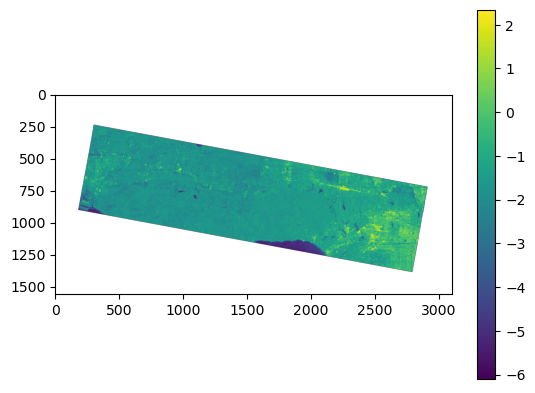

In [15]:
plt.imshow(pre_vv_c[-1])
plt.colorbar()

In [16]:
len(pre_vv_c)

10

In [17]:
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c[:],
    pre_vh_c[:],
    post_vv_c,
    post_vh_c,
    stride=16,
    agg="max",
    batch_size=512,
    memory_strategy="high",
    device=DEVICE,
)

Chips Traversed:   0%|       | 0/37 [00:00<?, ?it/s]

/Users/cmarshak/bekaert-team/distmetrics/src/distmetrics/tf_metric.py:76: UserWarning: A custom validator is returning a value other than `self`.
Returning anything other than `self` from a top level model validator isn't supported when validating via `__init__`.
See the `model_validator` docs (https://docs.pydantic.dev/latest/concepts/validators/#model-validators) for more details.
  m_dist = DiagMahalanobisDistance2d(dist=z_score, mean=mu, std=sigma)


In [18]:
dist = dist_ob.dist

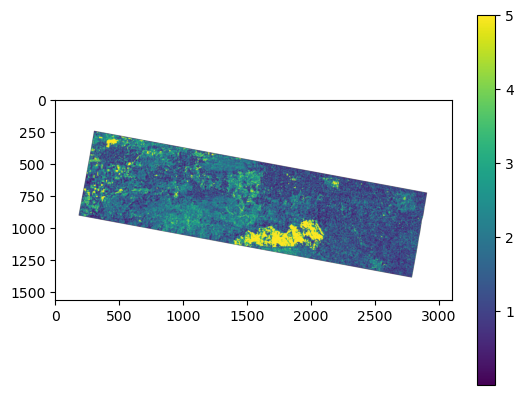

In [19]:
plt.imshow(dist_ob.dist, vmax=5)
plt.colorbar()

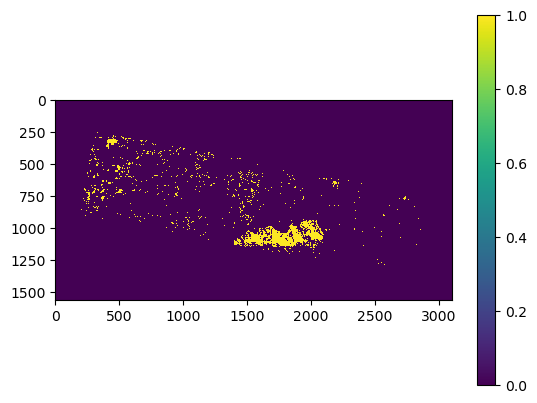

In [20]:
plt.imshow(dist_ob.dist > 3.5, vmax=1, interpolation="none")
plt.colorbar()

**Warninig**: the stat outputs of the function above are in `logits` NOT `gamma naught`. Hence `expit`!

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_44624/3498562707.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Mean Estimate VV ($\gamma$)")


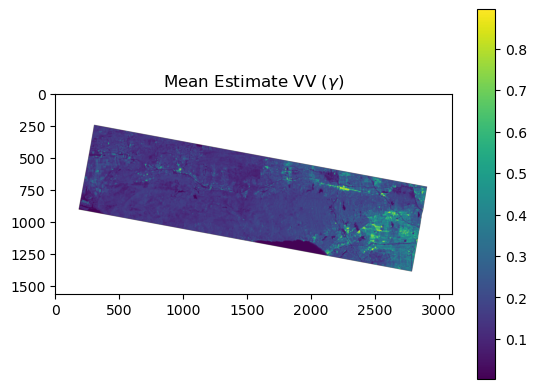

In [21]:
from scipy.special import expit

plt.title("Mean Estimate VV ($\gamma$)")
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

Can't really apply `expit` to `sigma`...

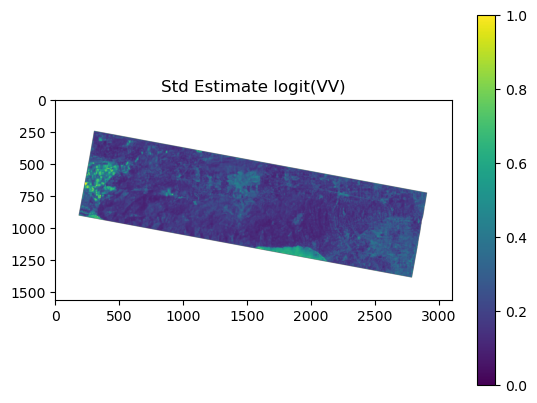

In [22]:
plt.title("Std Estimate logit(VV)")
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()